In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import sklearn 
import torch as pt
from torch import nn 


In [64]:
from torch.utils.data import TensorDataset, DataLoader

In [65]:
def preprocess_inputs(df):

    df = df.copy()
   

    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].dt.day
    df['Month of Journey'] = df['Date_of_Journey'].dt.month
    df = df.drop('Date_of_Journey', axis=1)
   
    
    # Convert and encode departure and arrival time to 4 different times of the day (morning, noon, afternoon, evening)
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour/6
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.hour/6
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    


    # Features from Additional info and total stops 
    
    df['Total_Stops']=df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Meal'] = df['Additional_Info'].map({'In-flight meal not included':1, 'No info':0})
    df['Baggage'] = df['Additional_Info'].map({'No check-in baggage included':1,'No info':0 })
    df = df.drop('Additional_Info', axis=1)
    
    
    # Source, Destination and Airline encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Airline'])], axis=1)
    df = df.drop(['Source', 'Destination','Airline'], axis=1)
   
    df = df.fillna(0) #to avoid null values 
    
    
    #find mean and standard deviation of the price
    mean = df['Price'].mean()
    std = df['Price'].std()
    min = df['Price'].min()
    max = df['Price'].max()

    
   
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = df['Price']
    X_scaled = (X -np.min(X))/(np.max(X)-np.min(X))
    y_scaled = (y -np.min(y))/(np.max(y)-np.min(y))

    
    # Train-test-validation split   
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


    """
    #exploratory data analysis
    corr = df.corr() #to see the correlation between each feature and the price 
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.corr(),cmap = 'coolwarm', annot=False)
    """
    
    return X_train, X_val, X_test, y_train, y_val, y_test, mean, std, min, max

In [66]:
#from google.colab import files
#uploaded = files.upload()




In [67]:
data = pd.read_excel('Data_Train.xlsx')

/var/folders/fk/fnjsfmtx3kz8w_rw6p8q4zzm0000gn/T/ipykernel_94902/3807267176.py:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(a

       Dep_Time  Arrival_Time  Duration  Total_Stops  Day of Journey  \
1502   0.478261      0.173913  0.348511         0.50           0.125   
3560   0.782609      0.521739  0.383538         0.25           0.750   
8846   0.478261      0.565217  0.045534         0.00           0.000   
3880   0.869565      1.000000  0.577933         0.25           0.125   
5862   0.782609      0.782609  0.514886         0.25           0.000   
...         ...           ...       ...          ...             ...   
10584  0.782609      0.826087  0.518389         0.25           0.875   
5851   0.260870      0.521739  0.625219         0.50           1.000   
9034   0.695652      0.173913  0.259194         0.25           0.125   
8241   0.695652      0.913043  0.103327         0.25           1.000   
9483   0.391304      0.826087  0.208406         0.25           0.125   

       Month of Journey  Meal  Baggage  S_Banglore  S_Chennai  ...  GoAir  \
1502           0.454545   1.0      0.0         0.0        

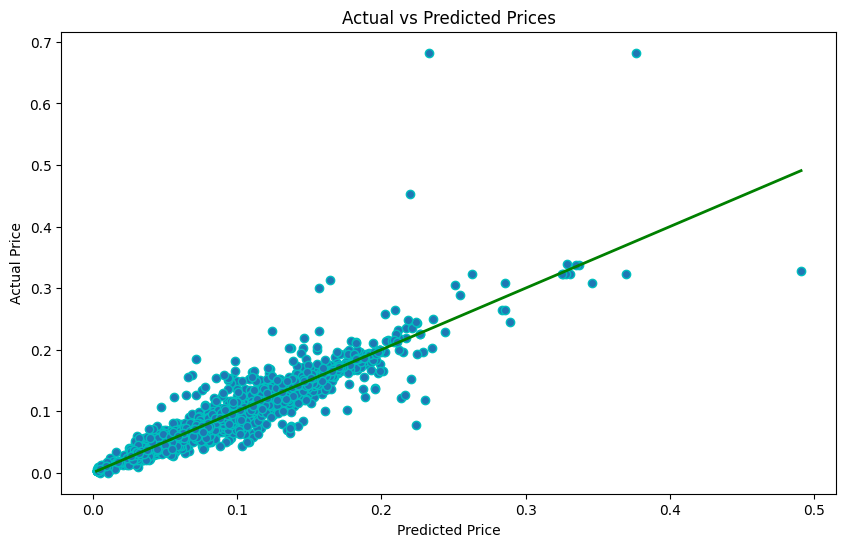

Linear : R2 Score = 0.6363
                   RMSE = 0.0357
                    MAE = 0.0234
                   MAPE = 3097032894381.49 %



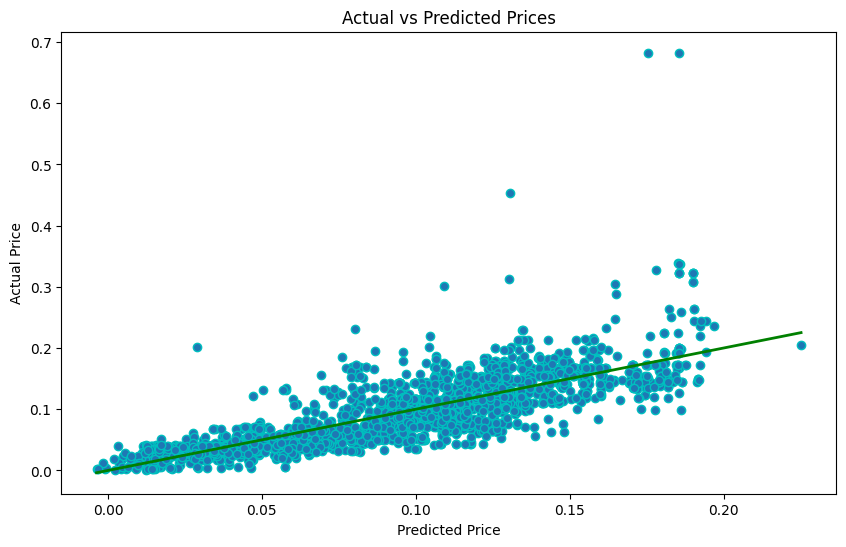

9918     0.091263
5687     0.024796
10404    0.056049
8933     0.109359
8375     0.154399
           ...   
6867     0.045297
9971     0.028089
10610    0.023639
10102    0.077708
6419     0.027780
Name: Price, Length: 1710, dtype: float64


In [68]:
X_train, X_test, X_val, y_train, y_test, y_val, mean, std, min, max  = preprocess_inputs(data)

print(X_train)
print(y_train)
print(X_test)
print(y_test)


print("-------- Training --------")
list1=[RandomForestRegressor(), LinearRegression()]
for i in list1:
    i.fit(X_train, y_train)

print("Random forest trained!")
print("Linear trained!")
print("---------- Done ----------")



for i in list1:
    y_pred = i.predict(X_val)
    if i == list1[0]:
        print("Random Forest : R2 Score = {:.4f}".format(r2_score(y_val, y_pred)))
        print("                   RMSE = {:.4f}".format(np.sqrt(mean_squared_error(y_val, y_pred))))
        print("                    MAE = {:.4f}".format(mean_absolute_error(y_val, y_pred)))
        print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_val, y_pred) * 100))
    else:
        print("Linear : R2 Score = {:.4f}".format(r2_score(y_val, y_pred)))
        print("                   RMSE = {:.4f}".format(np.sqrt(mean_squared_error(y_val, y_pred))))
        print("                    MAE = {:.4f}".format(mean_absolute_error(y_val, y_pred)))
        print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_val, y_pred)*100))        
       

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y_val, edgecolor='c')
    
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], c='g', lw=2)
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.show()

print(y_test)


A cpu device was detected.
tensor([[0.4783, 0.1739, 0.3485,  ..., 0.0000, 0.0000, 0.0000],
        [0.7826, 0.5217, 0.3835,  ..., 0.0000, 0.0000, 0.0000],
        [0.4783, 0.5652, 0.0455,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6957, 0.1739, 0.2592,  ..., 0.0000, 0.0000, 0.0000],
        [0.6957, 0.9130, 0.1033,  ..., 0.0000, 0.0000, 0.0000],
        [0.3913, 0.8261, 0.2084,  ..., 0.0000, 0.0000, 0.0000]])
tensor([0.1316, 0.1433, 0.1164,  ..., 0.1666, 0.0666, 0.1538])
Train Epoch: 0 	Loss: 6.228837
Val Epoch: 0 	Loss: 6.893092
Train Epoch: 1 	Loss: 5.947596
Val Epoch: 1 	Loss: 6.382585
Train Epoch: 2 	Loss: 5.878336
Val Epoch: 2 	Loss: 6.139789
Train Epoch: 3 	Loss: 5.846975
Val Epoch: 3 	Loss: 6.002895
Train Epoch: 4 	Loss: 5.828716
Val Epoch: 4 	Loss: 5.916934
Train Epoch: 5 	Loss: 5.816081
Val Epoch: 5 	Loss: 5.858974
Train Epoch: 6 	Loss: 5.806408
Val Epoch: 6 	Loss: 5.815936
Train Epoch: 7 	Loss: 5.798493
Val Epoch: 7 	Loss: 5.784024
Train Epoch: 8 	Loss: 5.791902
V

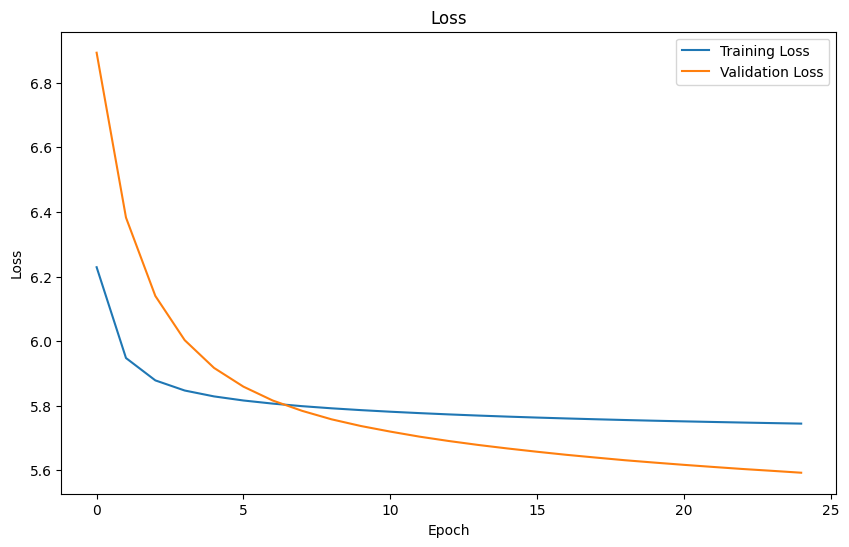

In [73]:
# Define your PyTorch neural network
# Number of Inputs: 31
# Number of Hidden Units: 100
# Number of Hidden Layers: 2
# Activation Function:  Relu
# Number of Outputs: 1

model = pt.nn.Sequential(
      pt.nn.Linear(31, 100),
      pt.nn.ReLU(),
      pt.nn.Linear(100, 100),
      pt.nn.ReLU(),
      pt.nn.Linear(100, 1),
      )


# Check to see if we have a GPU to use for training
device = 'cuda' if pt.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device)) 

# Print the name of the cuda device, if detected
if device=='cuda':
  print (pt.cuda.get_device_name(device=device))

# train the neural network model

x_train2 = pt.tensor(X_train.values,dtype=pt.float, device=device)
x_val2 = pt.tensor(X_val.values,dtype=pt.float, device=device)
x_test2 = pt.tensor(X_test.values,dtype=pt.float, device=device)

y_train2 = pt.tensor(y_train.values,dtype=pt.float, device=device)
y_val2 = pt.tensor(y_val.values,dtype=pt.float, device=device)
y_test2 = pt.tensor(y_test.values,dtype=pt.float, device=device)

print(x_train2)
print(y_train2)

loader_t = DataLoader(TensorDataset(x_train2,y_train2), batch_size = 4)

#define optimizer
optimizer = pt.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


#define criterion
criterion = pt.nn.MSELoss()


def train_model(model, loader, x_v, y_v, optimizer, criterion, epochs):
      history_train = []
      history_val = []

      
      for epoch in range(epochs):
            total_loss = 0
            model.train()
            count = 0
            for x_batch, y_batch in loader:
                  output_train = model(x_batch)
                  loss_train = criterion(output_train, y_batch)
                  total_loss += loss_train.item()
                  optimizer.zero_grad()
                  loss_train.backward()
                  optimizer.step()
                  count += 1
                
            
            history_train.append(total_loss)

            # calculate the validation loss
            model.eval()
            with pt.no_grad():
                  val_loss = 0
                  for i in range(len(x_v)):
                        output_val = model(x_v[i])
                        loss_val = criterion(output_val, y_v[i])
                        val_loss += loss_val.item()
                  
                  history_val.append(val_loss)

            
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, total_loss))
            print('Val Epoch: {} \tLoss: {:.6f}'.format(epoch,val_loss))

      
      
      #plot the loss and the validation loss in the same figure
      plt.figure(figsize=(10, 6))
      plt.plot(history_train, label='Training Loss')
      plt.plot(history_val, label='Validation Loss')
      plt.title("Loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

      
   
      
trained_model = train_model(model, loader_t, x_val2, y_val2, optimizer, criterion, epochs=25)

torch.Size([1710, 31])
torch.Size([1710])
(1710, 1)
(1710,)


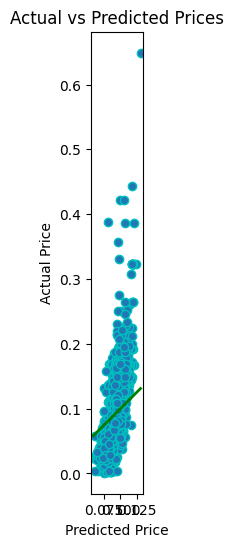

In [75]:
# Plot predictions vs. true values

print(x_test2.shape)
print(y_test2.shape)


with pt.no_grad():
    def graphPredictions(model, x, y):
        model.eval()                               # Set the model to inference mode

        predictions=[]                             # Track predictions
        actual=[]                                  # Track the actual labels

        x.to(device)
        y.to(device)
        model.to(device)

        for i in range(len(x)):
            # Single forward pass
            pred = model(x[i])    
            act = y[i]                           
            
            # Un-normalize pred and act using min-max normalization
            #pred = pred * (pt.max(y) - pt.min(y)) + pt.min(y)
           #act = y[i] * (pt.max(y) - pt.min(y)) + pt.min(y)

            # Save prediction and actual label
            predictions.append(pred.tolist())
            
            actual.append(act.tolist())

        predictions = np.array(predictions)
        actual = np.array(actual)
       # actual = actual-1

        
        print(predictions.shape)
        print(actual.shape)
        

        # Plot actuals vs predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(predictions, actual, edgecolor='c')
        plt.plot([predictions.min(), predictions.max()], [predictions.min(), predictions.max()], c='g', lw=2)
        plt.title("Actual vs Predicted Prices")
        plt.xlabel("Predicted Price")
        plt.ylabel("Actual Price")
        

        # Make the display equal in both dimensions
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

graphPredictions(model, x_test2, y_test2)